# Data Anaysis Project part1:

I am using Vancouver rental ads on craigslist to analyze rental market. Later, I will create the class to be able to analyze dynamically. Also, I will start collecting the data and save them to the CSV, so I can analyze the trend of the rental market as well. 

I will follow what I am learning from Google Data Analytics course to complete this project.

* Ask
* Prepare
* Process
* Analyze
* Share
* Act



## Overview of the project:

Analyze housing rental market in Fraser Valley to find out what is hot to real estate investors in this area. Iam going to create the code to analyze dynamically so the investors can apply in their area for their own use.  


## ASK 
    
    Find out what is 'HOT' in the market for investor, so I can find a property for them. Find out supply and demand of the rental housing market and calculate appropreate purchase price. 

#### What are the questions to ask?
Supply side:
* How much is the market rental price?
* What type of the rental is most popular and least popular?
* How many ads per day? Number of supply 
* Is rental price rising or decreasing over time?
* What is the correlation between housing price and rental price?
* From those questions, what is my prediction of the rental market? 

Demand side:
* What kind of propety does people look for rent?
* What is the price range they are looking for?
* What are the purposes of renting. (Who is looking for rent)


#### Review Google Data Analysis course and create checklist:
* Ask effective questions
* Define the problems
* Using structured thinking
* Communicate with others



## Prepare  

#### Using Craigslist add to collect market data: (Supply side)
Scrape craigslist rental housing pages and store in csv file. 

<a href='https://github.com/rileypredum/East-Bay-Housing-Web-Scrape/blob/master/EB_Apt_Prices_Final.ipynb'>Code: I will use this code and modify for my situation.  </a> <br>
<a href='https://towardsdatascience.com/web-scraping-craigslist-a-complete-tutorial-c41cea4f4981'>Explaning</a>


#### Review from Google Data Analysis course:
* Understand how data is generated and collect. 
    * The data is collected from Craigslist ads. 
* Identify and use different data formats, types, and structures. 
* Make sure data is unbiased and credible. 
    * The data is live advertisement, so it is great to see today's market price. However, craigslist doesn't seems today's most favorite site to advertize so it might not accurately show the reality. 
* Organize and protect data. 

In [1]:
# Import libralis
from requests import get
from bs4 import BeautifulSoup
from datetime import datetime
import pandas as pd
import numpy as np

from time import sleep
import re
from random import randint
from warnings import warn
from time import time
from IPython.display import clear_output

In [2]:
class Url:
    def __init__(self, city_name, sub_city=None, num_post=0):
        self.city_name = city_name
        self.sub_city = sub_city
        self.num_post = num_post
        self.url = self.get_url()
        
    def get_url(self):
        if self.city_name == 'Abbotsford':
            url = f'https://{self.city_name.lower()}.craigslist.org/search/apa?s={self.num_post}sort=date&bundleDuplicates=1&min_price=&max_price=&availabilityMode=0&sale_date=all+dates'
        else:
            url = f'https://{self.city_name.lower()}.craigslist.org/search/{self.sub_city}/apa?s={self.num_post}sort=date&bundleDuplicates=1&min_price=&max_price=&availabilityMode=0&sale_date=all+dates'
        return url 

In [3]:
# Vanvouver rental housing
url = Url("Vancouver", 'van')
url_ = url.url

response = get(url_)


soup = BeautifulSoup(response.text, 'html.parser')

posts = soup.find_all('li', class_='result-row')
print(type(posts)) # to double check that I got resultSet
print(len(posts)) # to double check I got 120 elements

<class 'bs4.element.ResultSet'>
122


In [4]:
%%time
# Find the total number of posts to find the limit of the pagination
city = 'Vancouver'
sub_city = 'van'
response = get(url_)
soup = BeautifulSoup(response.text, 'html.parser')
posts = soup.find_all('li', class_='result-row')
results_num = soup.find('div', class_='search-legend')
results_total = int(results_num.find('span', class_='totalcount').text)
print(f"Total number of search result: {results_total}")

# each page has 119 posts so each new page is defined as follows; s=120, s=240, .....
pages = np.arange(0, results_total+1, 120)

iterations = 0

post_date = []
post_cities = []
num_bedroom = []
sqfts = []
prices = []
post_titles = []
post_links = []

for page in pages:
    
    # get request
    url = Url(city_name=city, sub_city=sub_city, num_post=page)
    url_ = url.url
    response = get(url_)
    
    sleep(1)
    
    # throw warning for status code that are not 200
    if response.status_code != 200:
        warn(f'Request: {requests}; Status code: {response.status_code}')
        
    soup = BeautifulSoup(response.text, 'html.parser')
    
    posts = soup.find_all('li', class_='result-row')
    
    
    # Extract data 
    for post in posts:
        
        if post.find('span', class_ = 'result-hood') is not None:
            
            # Posting date
            post_datetime = post.find('time', class_='result-date')['datetime']
            post_date.append(post_datetime)
            
            # Neighbourhoods
            post_city = post.find('span', class_='result-hood').text.strip('( )')
            post_cities.append(post_city)
            
            # title text
            post_title = post.find('a', class_='result-title hdrlnk')
            post_title_text = post_title.text
            post_titles.append(post_title_text)
            
            # Post price in integer
            price = int(post.find('span', class_='result-price').text.split('$')[1].replace(',', ''))
            prices.append(price)
            
            # Post link
            post_link = post_title['href']
            post_links.append(post_link)
            
            if post.find('span', class_ = 'housing') is not None:
                
                #if the first element is accidentally square footage
                if 'ft2' in post.find('span', class_ = 'housing').text.split()[0]:
                    
                    #make bedroom nan
                    bedroom_count = np.nan
                    num_bedroom.append(bedroom_count)
                    
                    #make sqft the first element
                    sqft = int(post.find('span', class_ = 'housing').text.split()[0][:-3])
                    sqfts.append(sqft)
                    
                #if the length of the housing details element is more than 2
                elif len(post.find('span', class_ = 'housing').text.split()) > 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    num_bedroom.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = int(post.find('span', class_ = 'housing').text.split()[2][:-3])
                    sqfts.append(sqft)
                    
                #if there is num bedrooms but no sqft
                elif len(post.find('span', class_ = 'housing').text.split()) == 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    num_bedroom.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = np.nan
                    sqfts.append(sqft)                    
                
                else:
                    bedroom_count = np.nan
                    num_bedroom.append(bedroom_count)
                
                    sqft = np.nan
                    sqfts.append(sqft)
                
            #if none of those conditions catch, make bedroom nan, this won't be needed    
            else:
                bedroom_count = np.nan
                num_bedroom.append(bedroom_count)
                
                sqft = np.nan
                sqfts.append(sqft)
            #    num_bedroom.append(bedroom_count)
                
            #    sqft = np.nan
            #    sqfts.append(sqft)
        iterations += 1
        #print("Page" + str(iterations) + "Scraped Successfully!")   

Total number of search result: 3000
CPU times: total: 3.94 s
Wall time: 48.1 s


In [5]:
# create DataFrame
df = pd.DataFrame({'Post Datetime': post_date,
                   'City Code': city.upper()[:3],
                   'Area Code': sub_city.upper(),
                   'Post Title': post_titles,
                   'Post URL': post_links,
                  'Neighborhood': post_cities,
                  'Bedroom': num_bedroom,
                  'SQFT': sqfts,
                  'Price': prices})

print(df.info())

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3057 entries, 0 to 3056
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Post Datetime  3057 non-null   object 
 1   City Code      3057 non-null   object 
 2   Area Code      3057 non-null   object 
 3   Post Title     3057 non-null   object 
 4   Post URL       3057 non-null   object 
 5   Neighborhood   3057 non-null   object 
 6   Bedroom        2833 non-null   object 
 7   SQFT           2701 non-null   float64
 8   Price          3057 non-null   int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 215.1+ KB
None


,Post Datetime,City Code,Area Code,Post Title,Post URL,Neighborhood,Bedroom,SQFT,Price
0,2022-12-18 09:46,VAN,VAN,2 Level 3 Bed 3 Bath Luxury Penthouse with 2 P...,https://vancouver.craigslist.org/van/apa/d/van...,Olympic Village,4,2454.0,9995
1,2022-12-18 09:46,VAN,VAN,Furnished 7 Bed Luxury House with Waterfront V...,https://vancouver.craigslist.org/van/apa/d/wes...,West Vancouver,7,6000.0,19995
2,2022-12-18 09:46,VAN,VAN,Gorgeous 1 Bed + Den 1 Bath Furnished Condo wi...,https://vancouver.craigslist.org/van/apa/d/van...,Vancouver,1,675.0,3495
3,2022-12-18 09:46,VAN,VAN,Furnished 1 Bed 2.5 Bath Luxury Loft in Downto...,https://vancouver.craigslist.org/van/apa/d/van...,Vancouver,1,1400.0,4495
4,2022-12-18 09:46,VAN,VAN,Exceptional 4Bed 2Bath Furnished Detached Home...,https://vancouver.craigslist.org/van/apa/d/wes...,West Vancouver,4,2017.0,8195



## Process


* Create and transform data. 
* Maintan data integrity
    * Validility 
    * Accuracy
    * Completeness
    * Consistency
* Test data
### Clean Data
    * Remove duplicate    
    * Find null values then decide how to fill or drop entire row
    * Sorting
    * Filtering
Verify and report on cleaning results

Check the dataset I created from the Craigslist ad and final adjustment of the dataset to analyze the data. 

First to check the dataset:

#### Use visualization to understand the data. 

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3057 entries, 0 to 3056
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Post Datetime  3057 non-null   object 
 1   City Code      3057 non-null   object 
 2   Area Code      3057 non-null   object 
 3   Post Title     3057 non-null   object 
 4   Post URL       3057 non-null   object 
 5   Neighborhood   3057 non-null   object 
 6   Bedroom        2833 non-null   object 
 7   SQFT           2701 non-null   float64
 8   Price          3057 non-null   int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 215.1+ KB


Convert Post Datetime object to Datetime.

Connect City Code and Area Code then create Post Area Code. (In this DataFrame, it only contain one area of data but I am storeing 13 different area in CSV file. This code will distinguish the data in different regions.)

I would like to distingish FULLY FURNISHED suite and not furnished suite. I will create another column to show if it isTURE or FALSE. I noticed the title says if it is furnished suite or not (If not on the title, I assume that the suite is not furnished) 

Also, I noticed that the number of bedroom is string, so I will convert to integer. 

Sort DataFrame Descending order by Post Datetime.

Remove duplicate. 

Make Neighborhood all lowercase. 

Is there any oulier? 

In [8]:
# Convert Datetime then split seperate columns
df['Post Datetime'] = pd.to_datetime(df["Post Datetime"])
df['Post Date'] = df['Post Datetime'].dt.date
df['Post Time'] = df['Post Datetime'].dt.time

df["PostAreaCode"] = df["City Code"] + df["Area Code"]

lower_neighbor = []
for area in df["Neighborhood"]:
    neighbor = area.lower()
    lower_neighbor.append(neighbor)
df["Neighborhood"] = lower_neighbor

df = df[["PostAreaCode", 'Post Datetime', 'Post Date', 'Post Time', 'Post Title', 'Post URL', 'Neighborhood', 'Bedroom', 'SQFT', 'Price']]
df.head()

,PostAreaCode,Post Datetime,Post Date,Post Time,Post Title,Post URL,Neighborhood,Bedroom,SQFT,Price
0,VANVAN,2022-12-18 09:46:00,2022-12-18,09:46:00,2 Level 3 Bed 3 Bath Luxury Penthouse with 2 P...,https://vancouver.craigslist.org/van/apa/d/van...,olympic village,4,2454.0,9995
1,VANVAN,2022-12-18 09:46:00,2022-12-18,09:46:00,Furnished 7 Bed Luxury House with Waterfront V...,https://vancouver.craigslist.org/van/apa/d/wes...,west vancouver,7,6000.0,19995
2,VANVAN,2022-12-18 09:46:00,2022-12-18,09:46:00,Gorgeous 1 Bed + Den 1 Bath Furnished Condo wi...,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,1,675.0,3495
3,VANVAN,2022-12-18 09:46:00,2022-12-18,09:46:00,Furnished 1 Bed 2.5 Bath Luxury Loft in Downto...,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,1,1400.0,4495
4,VANVAN,2022-12-18 09:46:00,2022-12-18,09:46:00,Exceptional 4Bed 2Bath Furnished Detached Home...,https://vancouver.craigslist.org/van/apa/d/wes...,west vancouver,4,2017.0,8195


In [9]:
# Convert Bedroom number strings to Integer then NaN value to 0 assume 0 bedroom is studio appartment. 
df["Bedroom"] = pd.to_numeric(df["Bedroom"], errors='ignore').astype('Int64')
df["Bedroom"] = df["Bedroom"].fillna(0)

In [10]:
%%time
# Check if word 'furnished' in the title post. 
search_word = 'furnished'
furnished = []
for i in range(len(df)):
    post_title_list = df['Post Title'][i].lower().split(" ")
    if any(word == search_word for word in post_title_list):
        furnished.append(True)
    else:
        furnished.append(False)
df["IsFurnished"] = furnished

CPU times: total: 0 ns
Wall time: 14.4 ms


In [11]:
# Sort DataFrame by Datetime
df.sort_values(by="Post Datetime", axis=0, ascending=False, inplace=True)

In [12]:
# Remove duplicates by post title
df.drop_duplicates(subset="Post Title", inplace=True)
len(df)

2661

## Visualize data to understand the data



In [13]:
import matplotlib.pyplot as plt
plt.rcParams.update({"figure.figsize": (10, 6), "figure.dpi": 120})

In [14]:
#I found outlier so I drop it to start. 
df.drop(df[df["Price"] == 500000].index, axis=0, inplace=True)

## Price distribution

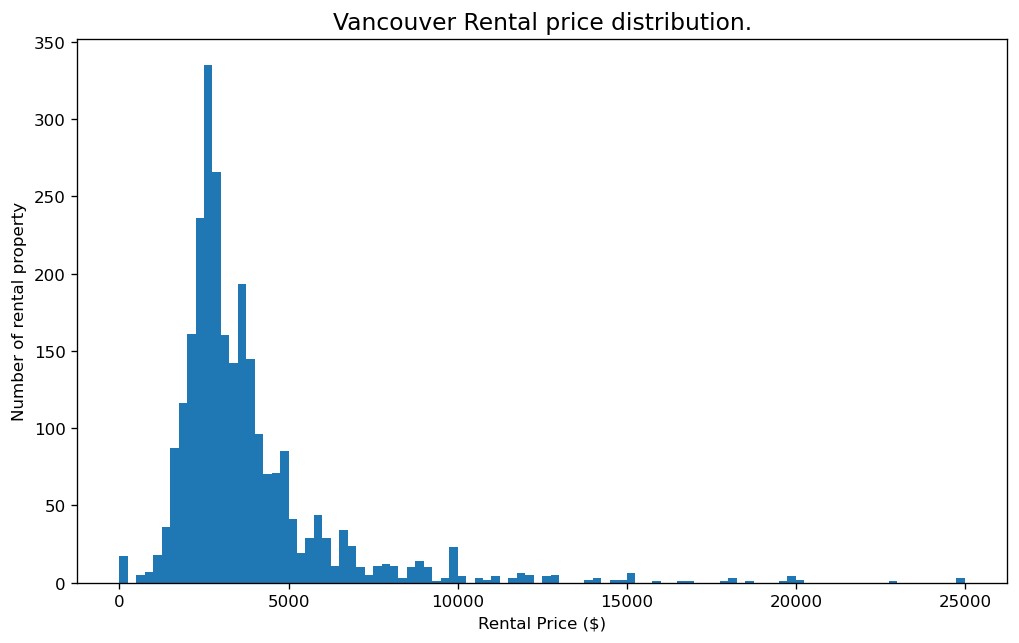

In [15]:
plt.hist(df["Price"], bins=100)
plt.title(f'{city} Rental price distribution.', fontsize=14)
plt.xlabel("Rental Price ($)")
plt.ylabel("Number of rental property");

## Relationship between Price and SQFT

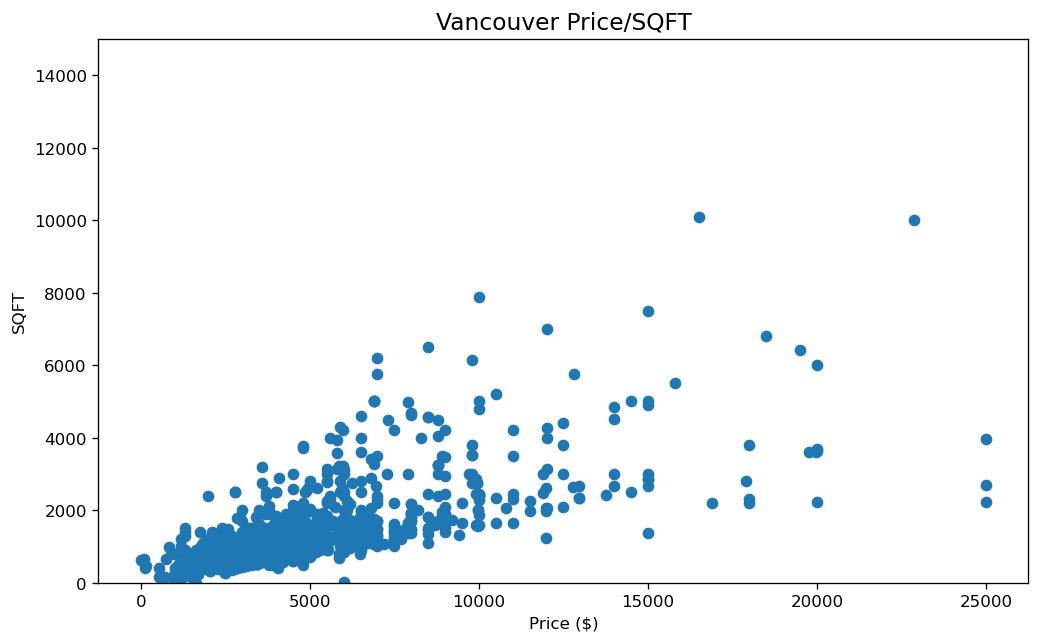

In [16]:
# Relationship between SQFT and Price
plt.scatter(x=df["Price"], y=df["SQFT"])
plt.ylim((0, 15000))
plt.title(f"{city} Price/SQFT", fontsize=14)
plt.xlabel(f"Price ($)")
plt.ylabel(f"SQFT");

Get the per SQFT price. 

In [17]:
df["Price/SQFT"] = df["Price"] / df["SQFT"]
p_per_sqft_df = df[["Neighborhood", "Bedroom", "Price", "Price/SQFT"]].sort_values(by="Price/SQFT", ascending=False)

In [18]:
# Drop rows if sqft is zero
p_per_sqft_df.fillna(0, inplace=True)
no_sqft_idx = p_per_sqft_df[p_per_sqft_df["Price/SQFT"] == 0].index
p_per_sqft_df.drop(no_sqft_idx, axis=0, inplace=True)

In [19]:
# Drop rows if Price/SQFT > $20
p_per_sqft_df = p_per_sqft_df[p_per_sqft_df["Price/SQFT"] < 20]

## Distribution of Per SQFT Price

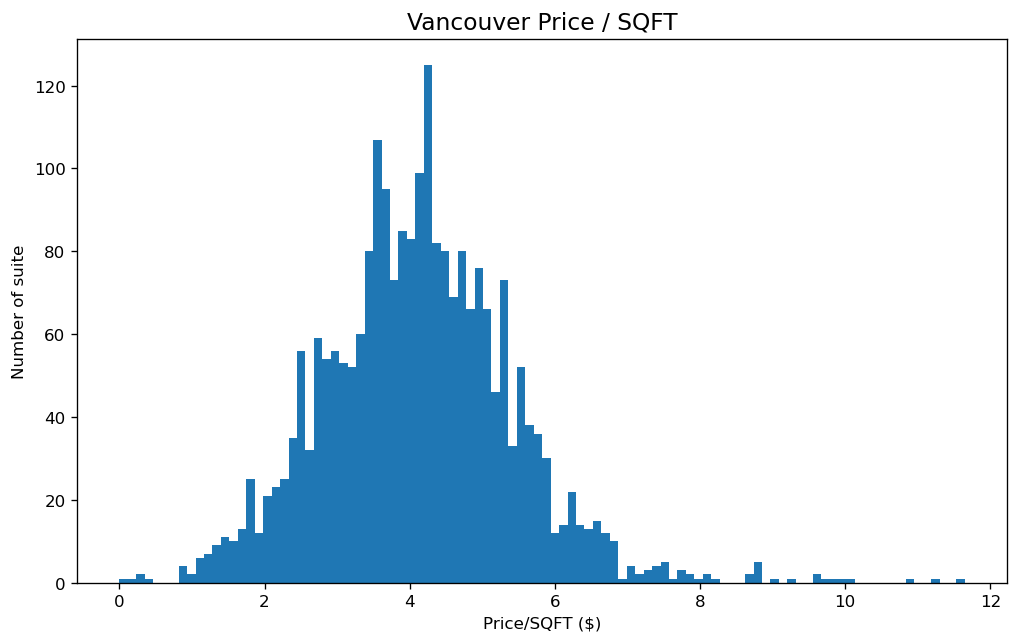

In [20]:
plt.hist(p_per_sqft_df["Price/SQFT"], bins=100)
plt.title(f"{city} Price / SQFT", fontsize=14)
plt.xlabel("Price/SQFT ($)")
plt.ylabel("Number of suite");

In [37]:
# Average, Min, Max Price/SQFT in each area
p_per_sqft_df["Neighborhood"].value_counts().head(15)

vancouver                            657
city of vancouver                    144
downtown vancouver                   133
yaletown                              90
1022 nelson street, vancouver, bc     81
kitsilano                             59
downtown                              48
west end                              45
coal harbour                          39
mount pleasant                        29
olympic village                       22
burnaby                               20
west vancouver                        15
east vancouver                        14
ubc                                   14
Name: Neighborhood, dtype: int64

In [43]:
# Drop all of the neighborhood is 1. 
p_per_neighbor = p_per_sqft_df.groupby(by="Neighborhood").agg({"Price/SQFT": ['count', 'mean', 'min', 'max']})
p_per_neighbor['Price/SQFT'].sort_values(by='count', ascending=False).head(15)

,count,mean,min,max
Neighborhood,,,,
vancouver,657,4.108610,0.153846,11.650485
city of vancouver,144,3.843011,0.001592,6.333333
downtown vancouver,133,5.024273,2.457996,10.877447
yaletown,90,4.871384,2.429730,8.996851
"1022 nelson street, vancouver, bc",81,4.852492,3.506122,5.499276
kitsilano,59,3.976454,2.111111,6.211111
downtown,48,5.400736,3.567568,10.105263
west end,45,4.931783,1.500000,7.096531
coal harbour,39,4.398417,2.765152,6.925743


## Number of ads on each bedroom

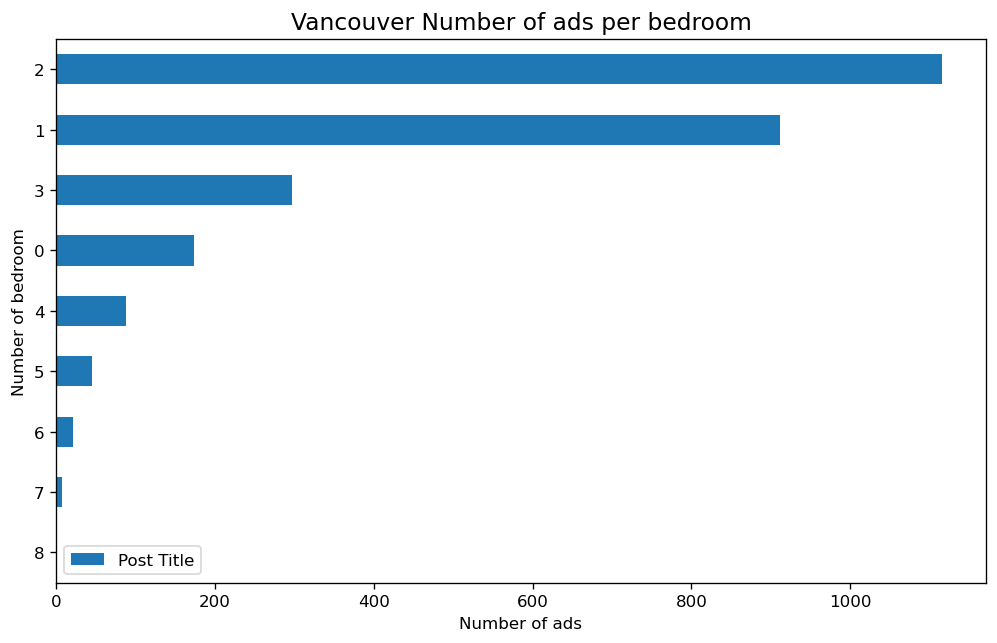

In [98]:
num_bed = df.groupby('Bedroom').agg({'Post Title': 'count'}).sort_values(by='Post Title', ascending=True)
num_bed.plot(kind='barh')
plt.title(f"{city} Number of ads per bedroom", fontsize=14)
plt.xlabel("Number of ads")
plt.ylabel("Number of bedroom");

In [99]:
# Percentage of the number of listing. 
num_bed["percent"] = num_bed / len(df) * 100
num_bed.rename(columns={'Post Title': "Number of Ads", 'percent': 'Percentage'}, inplace=True)

In [100]:
num_bed

,Number of Ads,Percentage
Bedroom,,
8,1,0.037594
7,7,0.263158
6,21,0.789474
5,45,1.691729
4,88,3.308271
0,174,6.541353
3,297,11.165414
1,912,34.285714
2,1115,41.917293


In [82]:
# Price less than $300
df[df['Price'] < 300]

,PostAreaCode,Post Datetime,Post Date,Post Time,Post Title,Post URL,Neighborhood,Bedroom,SQFT,Price,IsFurnished,Price/SQFT
183,VANVAN,2022-12-17 15:59:00,2022-12-17,15:59:00,Need help with housing,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,0,NaN,1,False,NaN
437,VANVAN,2022-12-16 18:53:00,2022-12-16,18:53:00,New basement suite in Riley Park Neighbourhood,https://vancouver.craigslist.org/van/apa/d/van...,riley park,1,NaN,140,False,NaN
642,VANVAN,2022-12-16 13:25:00,2022-12-16,13:25:00,Westsea Place - (Westend) - Studio & 1 Bedroom...,https://vancouver.craigslist.org/van/apa/d/del...,1644 nelson st.,0,NaN,0,False,NaN
1403,VANVAN,2022-12-14 10:31:00,2022-12-14,10:31:00,"SCAM $2,045 / 1br - 635ft2 - Suite 1 BR/Quiet ...",https://vancouver.craigslist.org/van/apa/d/van...,kits,1,NaN,0,False,NaN
1597,VANVAN,2022-12-13 11:30:00,2022-12-13,11:30:00,DO NOT LIVE HERE - 124 DUNLEVY AVE,https://vancouver.craigslist.org/van/apa/d/van...,city of vancouver,0,NaN,0,False,NaN
1783,VANVAN,2022-12-12 13:20:00,2022-12-12,13:20:00,Vancouver Furnished Master Bedroom for Rent,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,1,400.0,120,True,0.300000
2200,VANVAN,2022-12-08 14:02:00,2022-12-08,14:02:00,DO NOT RENT 1310 WEST 10TH AVE,https://vancouver.craigslist.org/van/apa/d/van...,fairview,1,NaN,0,False,NaN
2366,VANVAN,2022-12-06 21:27:00,2022-12-06,21:27:00,Sublet available Vancouver Dec 19th to Jan 2nd,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,1,NaN,90,False,NaN
2452,VANVAN,2022-12-06 11:56:00,2022-12-06,11:56:00,Nice Affordable Comfy and Cozy Scams,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,0,NaN,0,False,NaN
2469,VANVAN,2022-12-06 01:57:00,2022-12-06,01:57:00,No Cooking is Illegal,https://vancouver.craigslist.org/van/apa/d/van...,city of vancouver,1,NaN,0,False,NaN


In [ ]:
# One of the low price post (post around $100)
df.loc[less_than_300.index[0]]["Post URL"]

This post is daily rental. From this, I assume teh rental price around $100 would be daily rental suite. 

What about $1 or $0 posts?

In [ ]:
# $1 ads
one_dollar = df[df["Price"] == 1]
one_dollar["Post URL"]

In [ ]:
# $0 ads
zero_dollar = df[df["Price"] == 0]
zero_dollar

I think it most likely 0 dollar and 1 dollar ads are just not showing the price, so I will drop those rows from DataFrame. 

In [ ]:
# Drop low-end outliers rows
drop_index = []
for idx in one_dollar.index:
    drop_index.append(idx)
for idx in zero_dollar.index:
    drop_index.append(idx)
print(f"Original DataFrame Size:{len(df)}\nNumber of Dropped Rows: {len(drop_index)}")
df.drop(drop_index,axis=0, inplace=True)
print(f"DataFrame size after drop rows: {len(df)}")

## Analyze - 1

From the Histgram, the highest amount of rental is between 1000 to 5000. First I look what kind of market above 5000. 

I call this as 

## High-End market research


In [ ]:
# top 100 higest price 
top_100_price = df[['Post Datetime', 'Neighborhood', 'Bedroom', 'SQFT', 'Price', 'IsFurnished']].sort_values(
                by="Price", ascending=False).head(100)
top_100_price


In [ ]:
# What about distribution $5000 and up?
price_range = (5000, df["Price"].max())
plt.hist(df["Price"], bins=50, range=price_range)
plt.title(f'{city} Rental price distribution ${price_range[0]} - ${price_range[1]}', fontsize=14)
plt.xlabel("Rental Price ($)")
plt.ylabel("Number of rental property");

In [ ]:
# Get URL on 2 Bedroom suite in top 100. 
highest_two_bed = top_100_price[top_100_price['Bedroom'] == 2]
highest_two_bed_idx = highest_two_bed.index
for idx in highest_two_bed_idx:
    print(f'Index Number - {idx} : {df.loc[idx]["Post URL"]}')


#### What is 0.85% RULE?

This is the rough calculation to find out the purchase price to give 5 - 8% cash flow from your rental revenue with today's motgagerate. It's not accurate number but great place to start evaluating the home price for your investment. 

In [ ]:
# Average Price on those pent house
avg_rent = np.average(highest_two_bed["Price"][1:].to_numpy())
max_rent = np.max(highest_two_bed["Price"][1:].to_numpy())
# 0.85% RULE
avg_house_p = np.round(avg_rent / (0.85/100), 2)
max_house_p = np.round(max_rent / (0.85/100), 2)
print(f"Price between ${avg_house_p*0.8} - ${max_house_p}")

In [ ]:
# Rental price higher than $5000.
more_than_5000 = df[df["Price"] > 5000]
more_than_5000.groupby(by=["Bedroom", "IsFurnished"]).agg({'SQFT': ["min", "max"],
                                                         "Price": ['min', 'max', 'count']})

In [ ]:
# top 10 most expensive rental in Vancouver
top_10 = top_100_price.head(10)
top_10

In [ ]:
# Then get the URL on those top 10 most expensive rental in Vancouver. 
top_10_idx = top_10.index
for idx in top_10_idx:
    print(f'Index Number - {idx}/Number of Bedroom - {df.loc[idx]["Bedroom"]}/SQFT - {df.loc[idx]["SQFT"]}/Location - {df.loc[idx]["Neighborhood"]}\n{df.loc[idx]["Post URL"]}')

From above data, Downtown Vanvouver rental market is different world. I must make decision to define what is the outlier of high-end rental. 

If the number of the high-end prices are large enough, I can make DataFrame for only high-end and search for the high-end market opportunities. 

Clearly, I should not mix with regular market and high-end market because it will provide me biased price average to determin the valuse of the house. 

I am wondering that <a href='https://www03.cmhc-schl.gc.ca/hmip-pimh/en/TableMapChart/Table?TableId=2.1.31.3&GeographyId=2410&GeographyTypeId=3&DisplayAs=Table&GeograghyName=Vancouver'>CMHC Vancouver rental market report</a> concerns about those outliers. 

## Analyze - 2 


## Analyze under 5000, and i call them for regular market. 
* What is the percentage of the Furnished rental suite? 
* Is there any price different? 
* How many bedroom suite has most on ads? And is it any different in area?
* How much is the rental price in general? 


Tne price around $100 is most likely daily rental so I will store in different variable so I might be able to do something with them. 

In [ ]:
# What about distribution $0 - $5000?
price_range = (0, 5000)
plt.hist(df["Price"], bins=50, range=price_range)
plt.title(f'{city} Rental price distribution ${price_range[0]} - ${price_range[1]}', fontsize=14)
plt.xlabel("Rental Price ($)")
plt.ylabel("Number of rental property");

In [ ]:
day_rental = df[df["Price"].between(10, 300)]
day_rental

In [ ]:
# Drop the rental price over $5000. 
under_5000 = df.drop(more_than_5000.index, axis=0)
print(f'Drop {len(more_than_5000)} rows and data contains {len(under_5000)} rows of data.')

In [ ]:
# then also drop daily rentals
under_5000 = under_5000.drop(day_rental.index, axis=0)
print(f'Drop {len(day_rental)} rows and data contains {len(under_5000)} rows of data.')

In [ ]:
# What is the top 10 highest price on under $5000. Is it no outlier?
under_5000.sort_values(by="Price", ascending=False).head(10)

In [ ]:
# How many rentals are $5000?
under_5000[under_5000["Price"] == 5000] 

In [ ]:
# What is the cheapest rent?
under_5000.sort_values(by="Price").head(20)

In [ ]:
# Count how many rentals are furnished 
num_furnished_suite = df[df['IsFurnished'] == True]["IsFurnished"].count()
num_unfurnished_suite = len(df) - num_furnished_suite
furnished_suite_percent = np.round((num_furnished_suite / len(df)) * 100, 2)
print(f"Number of furnished suite is {num_furnished_suite}, and it's {furnished_suite_percent}% of the entire list.")

In [ ]:
# Find out the number of ads on each bedrooms number.  
num_bed = np.sort(df["Bedroom"].unique())
suite_counts = []
for i in range(len(num_bed)):
    suite_count = len(df[df['Bedroom'] == num_bed[i]])
    suite_counts.append(suite_count)
    #print(f'Number of {num_bed[i]} Bedroom suite: {len(df[df["Bedroom"] == num_bed[i]])}')
#print(f"List of suite counts: {suite_counts}")

In [ ]:
# Find out Mean, Max, Min of SQFT and Price of each bedroom and SUM of furnished suite and total suite on each bedroom. 
df_count = df.groupby(by=['Bedroom']).agg({'SQFT': ['mean', 'max', 'min'],
                                                 'Price': ['mean', 'max', 'min'],
                                                  'IsFurnished': ['sum', 'count']})
df_count['percent furnished'] = df_count['IsFurnished']['sum'] / df_count["IsFurnished"]['count']
df_count

In [ ]:
# Price per furnished suit on each bedroom
#df_price_furnished = df.drop(['Post Datetime', 'Post Title', 'Post URL', 'Neighborhood'], axis=1)
df_price_furnished = df.groupby(['Bedroom', 'IsFurnished']).agg({'Price': ['mean', 'max', 'min', 'count'],
                                                               "SQFT": ['mean', 'max', 'min']})
df_price_furnished

Dropped extrimely low price add, and it seems no outlier on the price

In [ ]:
# Count how many ads per day.1=Mon, 2=Tue, ......, 7=Sun
df["Weekday"] = df["Post Datetime"].dt.isocalendar().day
num_ad_per_day_df = df.groupby('Post Date').agg({'Post Title': 'count',
                                                "Weekday": 'first'})

num_ad_per_day_df

Which day of the week have more ads? 

Is there any day of the week that having more ads than others? 

## Share

#### Data Visualization:
The most important thing is what information do I want to tell. 

In [ ]:
df_price_furnished["Price"]["mean"].unstack().plot(kind='bar')
plt.title(f'{city} AVG Rental Price Furnished suite vs non-Furnished suite', fontsize=16)
plt.xlabel('Number of bedroom')
plt.ylabel('Price ($)')
plt.ylim((0, 15000));

## Act